In [1]:
import pandas as pd
from preprocess import prepare_for_quantile_transformer
from model import QuantileEncoderDecoderTransformer, train_one_epoch, evaluate
from model import build_cfg_from_prepared
from typing import Dict, Any, Optional, Tuple
import os, json, pickle
from dataclasses import asdict
import numpy as np
import matplotlib.pyplot as plt
import torch
import time

In [2]:
from preprocess import cut_last_full_days

df = pd.read_csv("raw_data/raw_data_merged.csv")
df_cut = cut_last_full_days(df)
prepared = prepare_for_quantile_transformer(
    df=df_cut,
    target_col="zuctovacia cena za odchylku",
    L=96*7,     # napr. 7 dní histórie (7*96 = 672)
    H=96,       # 1 deň dopredu
)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
cfg = build_cfg_from_prepared(
    prepared,
    horizon=96,
    use_known_future=True,
    crossing_penalty_weight=0.0,
)

In [18]:
def save_bundle(
    path: str,
    model: torch.nn.Module,
    cfg,  # QuantileTransformerConfig
    feature_cols: Dict[str, Any],
    scalers: Dict[str, Any],
    extra: Optional[Dict[str, Any]] = None,
) -> None:
    """
    Uloží:
      - model.state_dict()
      - cfg (asdict)
      - feature_cols (napr. prepared.feature_cols)
      - scalers (prepared.scalers) cez pickle
      - extra metadata (voliteľné)
    """
    os.makedirs(path, exist_ok=True)

    # 1) model weights
    torch.save(model.state_dict(), os.path.join(path, "model_state.pt"))

    # 2) cfg + feature cols + extra do JSON
    meta = {
        "cfg": asdict(cfg),
        "feature_cols": feature_cols,
        "extra": extra or {},
    }
    with open(os.path.join(path, "meta.json"), "w", encoding="utf-8") as f:
        json.dump(meta, f, ensure_ascii=False, indent=2)

    # 3) scalers pickle
    with open(os.path.join(path, "scalers.pkl"), "wb") as f:
        pickle.dump(scalers, f, protocol=pickle.HIGHEST_PROTOCOL)


def load_bundle(
    path: str,
    model_class,  # QuantileEncoderDecoderTransformer
    cfg_class,    # QuantileTransformerConfig
    device: torch.device,
) -> Tuple[torch.nn.Module, Any, Dict[str, Any], Dict[str, Any]]:
    """
    Načíta bundle a vráti: (model, cfg, feature_cols, scalers)
    """
    meta_path = os.path.join(path, "meta.json")
    state_path = os.path.join(path, "model_state.pt")
    scalers_path = os.path.join(path, "scalers.pkl")

    if not os.path.exists(meta_path) or not os.path.exists(state_path) or not os.path.exists(scalers_path):
        raise FileNotFoundError(f"Missing bundle files in: {path}")

    with open(meta_path, "r", encoding="utf-8") as f:
        meta = json.load(f)

    cfg = cfg_class(**meta["cfg"])
    feature_cols = meta["feature_cols"]

    with open(scalers_path, "rb") as f:
        scalers = pickle.load(f)

    model = model_class(cfg).to(device)
    state = torch.load(state_path, map_location=device)
    model.load_state_dict(state)
    model.eval()

    return model, cfg, feature_cols, scalers


In [19]:
bundle_dir = "artifacts/qt_transformer_v1"

In [20]:
model = QuantileEncoderDecoderTransformer(cfg).to(device)

opt = torch.optim.AdamW(model.parameters(), lr=3e-4)

def format_seconds(s: float) -> str:
    m = int(s // 60)
    sec = s - 60 * m
    return f"{m:02d}:{sec:04.1f}"


def train_model(
    model,
    prepared,
    cfg,
    device,
    epochs: int = 10,
    lr: float = 3e-4,
    grad_clip: float = 1.0,
    bundle_dir: Optional[str] = None,
):
    """
    Trénuje model a (voliteľne) ukladá najlepší checkpoint podľa val loss.

    Vypisované metriky:
      - train_loss: priemerný pinball loss (a prípadne crossing penalty) na tréningových batchoch
      - val_loss:   to isté na validačných batchoch
      - best_val:   najlepšia validačná hodnota doteraz
    """
    model = model.to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr)

    best_val = float("inf")

    print("Training started")
    print(f"  epochs        : {epochs}")
    print(f"  lr            : {lr}")
    print(f"  grad_clip     : {grad_clip}")
    print(f"  horizon (H)   : {cfg.horizon}")
    print(f"  quantiles (Q) : {len(cfg.quantiles)} -> {list(cfg.quantiles)}")
    print(f"  scale_target  : {'y' in prepared.scalers} (loss is computed on scaled target if True)")
    print("-" * 90)
    print(
        f"{'epoch':>5} | {'train_loss':>10} | {'val_loss':>10} | {'best_val':>10} | {'Δ val':>10} | {'time':>7} | note"
    )
    print("-" * 90)

    for epoch in range(epochs):
        t0 = time.time()

        tr = train_one_epoch(model, prepared.train_loader, opt, device, grad_clip=grad_clip)
        va = evaluate(model, prepared.val_loader, device)

        dt = time.time() - t0
        delta = va - best_val

        improved = va < best_val
        note = "✅ improved" if improved else "—"

        if improved:
            best_val = va
            delta_str = f"{delta: .3e}" if epoch > 0 else "   n/a"
            # uložiť checkpoint iba pri zlepšení
            if bundle_dir is not None:
                save_bundle(
                    path=bundle_dir,
                    model=model,
                    cfg=cfg,
                    feature_cols=prepared.feature_cols,
                    scalers=prepared.scalers,
                    extra={
                        "best_val": float(best_val),
                        "epoch": int(epoch),
                        "target_col": prepared.feature_cols["target"][0],
                        "L": int(prepared.arrays["train"]["X_hist"].shape[1]),
                        "H": int(cfg.horizon),
                        "notes": "Quantile encoder-decoder transformer (best checkpoint)",
                    },
                )
        else:
            delta_str = f"{delta: .3e}"

        print(
            f"{epoch:5d} | {tr:10.6f} | {va:10.6f} | {best_val:10.6f} | {delta_str:>10} | {format_seconds(dt):>7} | {note}"
        )

    print("-" * 90)
    print(f"Done. Best val_loss = {best_val:.6f}")
    return best_val


/home/mremen/.virtualenvs/transformer/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


In [21]:
best_val = train_model(
    model=model,
    prepared=prepared,
    cfg=cfg,
    device=device,
    epochs=10,
    lr=3e-4,
    grad_clip=1.0,
    bundle_dir=bundle_dir,  # ukladá len keď sa zlepší
)

Training started
  epochs        : 10
  lr            : 0.0003
  grad_clip     : 1.0
  horizon (H)   : 96
  quantiles (Q) : 9 -> [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
  scale_target  : True (loss is computed on scaled target if True)
------------------------------------------------------------------------------------------
epoch | train_loss |   val_loss |   best_val |      Δ val |    time | note
------------------------------------------------------------------------------------------
    0 |   0.306523 |   0.285387 |   0.285387 |        n/a | 00:21.9 | ✅ improved
    1 |   0.118688 |   0.162677 |   0.162677 | -1.227e-01 | 00:21.9 | ✅ improved
    2 |   0.077744 |   0.090329 |   0.090329 | -7.235e-02 | 00:21.9 | ✅ improved
    3 |   0.051604 |   0.072419 |   0.072419 | -1.791e-02 | 00:21.9 | ✅ improved
    4 |   0.046553 |   0.088959 |   0.072419 |  1.654e-02 | 00:21.9 | —
    5 |   0.046777 |   0.061512 |   0.061512 | -1.091e-02 | 00:21.9 | ✅ improved
    6 |   0.044277 |   0

In [22]:
# po treningu
save_bundle(
    path=bundle_dir,
    model=model,
    cfg=cfg,
    feature_cols=prepared.feature_cols,
    scalers=prepared.scalers,
    extra={
        "target_col": "zuctovacia cena za odchylku",
        "L": 96*7,
        "H": 96,
        "notes": "Quantile encoder-decoder transformer",
    }
)
print("Saved to:", bundle_dir)


Saved to: artifacts/qt_transformer_v1


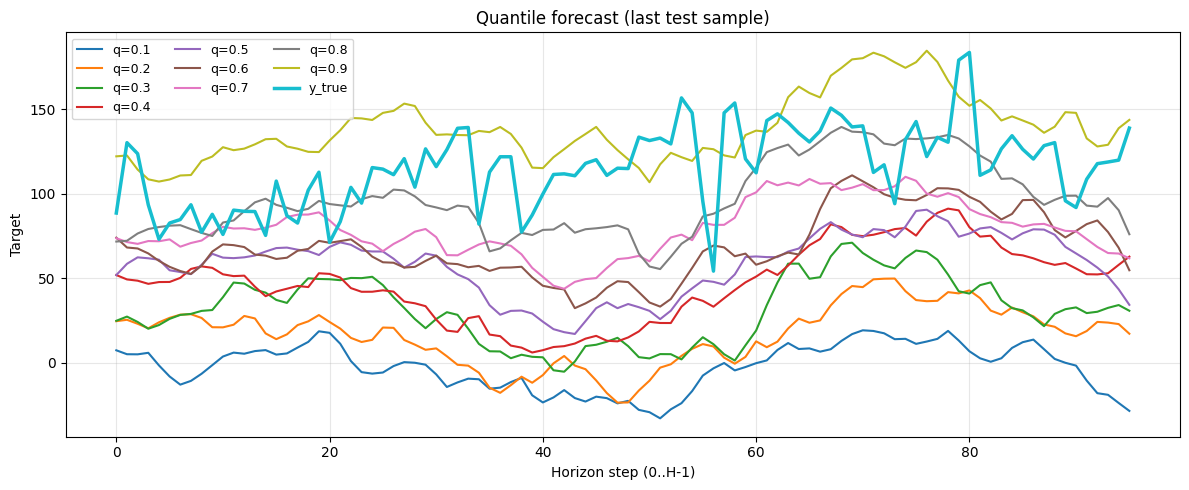

In [23]:
# --- helper: inverse transform for y (and optionally for x) ---
def inverse_scale_y(y_scaled: np.ndarray, y_scaler) -> np.ndarray:
    """
    y_scaled: (..., H) or (..., H, Q)
    returns same shape in original units
    """
    if y_scaler is None:
        return y_scaled

    orig_shape = y_scaled.shape
    flat = y_scaled.reshape(-1, 1)
    inv = y_scaler.inverse_transform(flat).reshape(orig_shape)
    return inv


@torch.no_grad()
def predict_one_sample(
    model,
    prepared,
    device,
    split: str = "test",
    sample_idx: int = -1,  # -1 = posledný sample
):
    """
    Vráti (yhat_q, y_true) v *pôvodných jednotkách*.
    yhat_q: (H, Q)
    y_true: (H,)
    """
    model.eval()

    arrays = prepared.arrays[split]
    X_hist = arrays["X_hist"]
    X_fut  = arrays["X_fut"]
    Y_fut  = arrays["Y_fut"]

    # vyber sample
    x_hist = X_hist[sample_idx]            # (L, d_enc)
    y_true = Y_fut[sample_idx]             # (H,)
    x_fut  = None if X_fut is None else X_fut[sample_idx]  # (H, d_dec)

    # torch batch dim
    x_hist_t = torch.from_numpy(x_hist).unsqueeze(0).to(device)  # (1,L,d_enc)
    x_fut_t  = None if x_fut is None else torch.from_numpy(x_fut).unsqueeze(0).to(device)

    # forward
    yhat_q_t = model(x_hist_t, x_fut_t)    # (1,H,Q)
    yhat_q = yhat_q_t.squeeze(0).detach().cpu().numpy()  # (H,Q)

    # inverse scale target
    y_scaler = prepared.scalers.get("y", None)
    yhat_q = inverse_scale_y(yhat_q, y_scaler)  # (H,Q)
    y_true = inverse_scale_y(y_true, y_scaler)  # (H,)

    return yhat_q, y_true


def plot_quantile_forecast(
    yhat_q: np.ndarray,
    quantiles,
    y_true: np.ndarray = None,
    title: str = "Quantile forecast",
):
    """
    yhat_q: (H, Q)
    quantiles: list/array length Q
    y_true: (H,) optional
    """
    H, Q = yhat_q.shape
    x = np.arange(H)

    plt.figure(figsize=(12, 5))
    # kvantilové krivky
    for j, q in enumerate(quantiles):
        plt.plot(x, yhat_q[:, j], label=f"q={q:.1f}")

    # skutočnosť
    if y_true is not None:
        plt.plot(x, y_true, linewidth=2.5, label="y_true")

    plt.title(title)
    plt.xlabel("Horizon step (0..H-1)")
    plt.ylabel("Target")
    plt.legend(ncol=3, fontsize=9)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


# --- použitie (ak už máš model a prepared) ---
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

yhat_q, y_true = predict_one_sample(model, prepared, device, split="test", sample_idx=-1)

quantiles = list(cfg.quantiles)  # alebo model.quantiles.cpu().numpy().tolist()
plot_quantile_forecast(
    yhat_q=yhat_q,
    quantiles=quantiles,
    y_true=y_true,
    title="Quantile forecast (last test sample)",
)


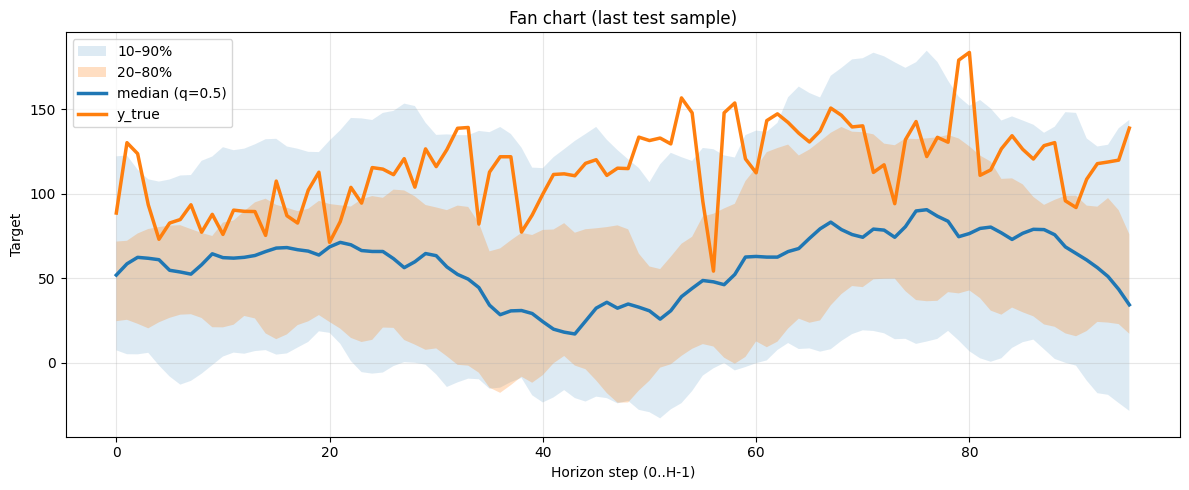

In [24]:
def plot_fan_chart(yhat_q: np.ndarray, quantiles, y_true: np.ndarray = None, title="Quantile fan chart"):
    H, Q = yhat_q.shape
    x = np.arange(H)

    q = np.array(quantiles)
    def get_q(level):
        j = int(np.where(np.isclose(q, level))[0][0])
        return yhat_q[:, j]

    q10 = get_q(0.1); q25 = get_q(0.2) if 0.2 in q else None
    q50 = get_q(0.5); q75 = get_q(0.8) if 0.8 in q else None
    q90 = get_q(0.9)

    plt.figure(figsize=(12, 5))
    # pásma
    plt.fill_between(x, q10, q90, alpha=0.15, label="10–90%")
    if q25 is not None and q75 is not None:
        plt.fill_between(x, q25, q75, alpha=0.25, label="20–80%")

    # medián
    plt.plot(x, q50, linewidth=2.5, label="median (q=0.5)")

    if y_true is not None:
        plt.plot(x, y_true, linewidth=2.5, label="y_true")

    plt.title(title)
    plt.xlabel("Horizon step (0..H-1)")
    plt.ylabel("Target")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_fan_chart(yhat_q, quantiles, y_true, title="Fan chart (last test sample)")


In [25]:
def _inverse_scale_y(y_scaled: np.ndarray, y_scaler) -> np.ndarray:
    if y_scaler is None:
        return y_scaled
    shp = y_scaled.shape
    flat = y_scaled.reshape(-1, 1)
    inv = y_scaler.inverse_transform(flat).reshape(shp)
    return inv

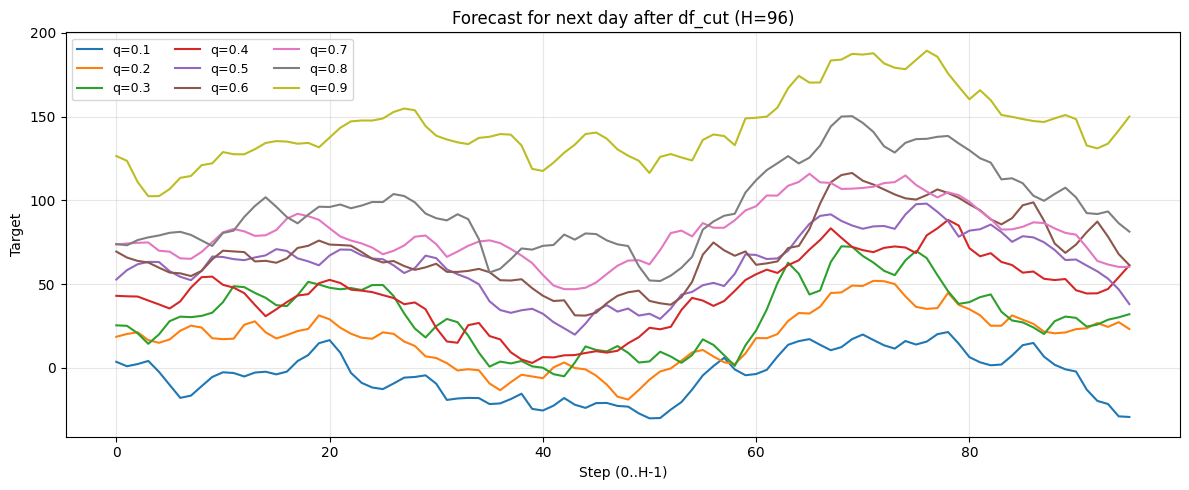

In [26]:
from preprocess import add_time_features_15min, add_lag_features


@torch.no_grad()
def predict_next_day_from_dfcut(work_df_cut: pd.DataFrame, prepared, model, cfg, device,
                                period_col="period_end", tz=None):
    """
    Vezme posledné okno z df_cut a predikuje ďalších H krokov.
    Vracia yhat_q (H,Q) v pôvodných jednotkách.
    """
    # Urob rovnaké feature engineering kroky ako v prepare_for_quantile_transformer,
    # ale použijeme presne tie stĺpce, ktoré si mal uložené v prepared.feature_cols.
    tmp = work_df_cut.copy()
    tmp[period_col] = pd.to_datetime(tmp[period_col])
    tmp = tmp.sort_values(period_col).set_index(period_col)

    # replikujeme minimum z prepare:
    if "Stav sustavy" in tmp.columns and tmp["Stav sustavy"].dtype == object:
        dummies = pd.get_dummies(tmp["Stav sustavy"], prefix="state", dtype=np.float32)
        tmp = tmp.drop(columns=["Stav sustavy"]).join(dummies)

    tmp = add_time_features_15min(tmp, tz=tz)
    tmp = add_lag_features(tmp, target_col=prepared.feature_cols["target"][0])

    enc_cols = prepared.feature_cols["enc"]
    dec_cols = prepared.feature_cols["dec"]
    L = cfg.horizon * 7  # u teba 96*7; ak chceš presne, môžeš ho uložiť do extra a čítať odtiaľ

    # Pozor: L nevieme z cfg, takže lepšie zober z prepared:
    L = prepared.arrays["train"]["X_hist"].shape[1]
    H = cfg.horizon

    tmp = tmp.dropna()
    if len(tmp) < L:
        raise ValueError("Not enough rows after feature engineering/dropna for last window.")

    # posledné historické okno
    X_hist_last = tmp[enc_cols].to_numpy(dtype=np.float32)[-L:]                 # (L, d_enc)

    # budúce kovariáty (kalendár) na nasledujúcich H krokov:
    # vytvoríme budúci index po konci df_cut
    last_ts = tmp.index[-1]
    freq = pd.infer_freq(tmp.index) or "15min"
    fut_index = pd.date_range(last_ts + pd.Timedelta(freq), periods=H, freq=freq)

    fut_df = pd.DataFrame(index=fut_index)
    fut_df = add_time_features_15min(fut_df, tz=tz)
    X_fut_last = fut_df[dec_cols].to_numpy(dtype=np.float32)                    # (H, d_dec)

    # škálovanie podľa prepared.scalers
    if "enc" in prepared.scalers:
        enc_scaler = prepared.scalers["enc"]
        X_hist_last = enc_scaler.transform(X_hist_last)

    if "dec" in prepared.scalers and X_fut_last is not None:
        dec_scaler = prepared.scalers["dec"]
        X_fut_last = dec_scaler.transform(X_fut_last)

    # torch + forward
    xh = torch.from_numpy(X_hist_last).unsqueeze(0).to(device)                  # (1,L,d_enc)
    xf = torch.from_numpy(X_fut_last).unsqueeze(0).to(device)                   # (1,H,d_dec)

    yhat_q = model(xh, xf).squeeze(0).cpu().numpy()                             # (H,Q)

    # inverse scale y
    y_scaler = prepared.scalers.get("y", None)
    yhat_q = _inverse_scale_y(yhat_q, y_scaler)

    return fut_index, yhat_q

def plot_quantiles(yhat_q: np.ndarray, quantiles, title="Quantile forecast"):
    H, Q = yhat_q.shape
    x = np.arange(H)
    plt.figure(figsize=(12,5))
    for j, q in enumerate(quantiles):
        plt.plot(x, yhat_q[:, j], label=f"q={q:.1f}")
    plt.title(title)
    plt.xlabel("Step (0..H-1)")
    plt.ylabel("Target")
    plt.grid(True, alpha=0.3)
    plt.legend(ncol=3, fontsize=9)
    plt.tight_layout()
    plt.show()

fut_index, yhat_q = predict_next_day_from_dfcut(df_cut, prepared, model, cfg, device, tz=None)
plot_quantiles(yhat_q, list(cfg.quantiles), title="Forecast for next day after df_cut (H=96)")

In [27]:
import numpy as np
import torch

@torch.no_grad()
def test_bias_summary(model, prepared, device, q=0.5):
    model.eval()
    q_list = model.quantiles.detach().cpu().numpy().tolist()
    j = int(np.where(np.isclose(q_list, q))[0][0])

    y_scaler = prepared.scalers.get("y", None)

    diffs = []
    for batch in prepared.test_loader:
        if len(batch) == 2:
            x_hist, y_true = batch
            x_fut = None
        else:
            x_hist, x_fut, y_true = batch
            x_fut = x_fut.to(device)

        x_hist = x_hist.to(device)
        y_true = y_true.to(device)

        yhat_q = model(x_hist, x_fut)  # (B,H,Q)
        yhat = yhat_q[..., j].detach().cpu().numpy()
        yt   = y_true.detach().cpu().numpy()

        # inverse scale
        if y_scaler is not None:
            yhat = inverse_scale_y(yhat, y_scaler)
            yt   = inverse_scale_y(yt, y_scaler)

        diffs.append((yhat - yt).reshape(-1))

    diffs = np.concatenate(diffs)
    print("median error (q50):", np.median(diffs))
    print("mean error (q50):  ", np.mean(diffs))
    print("% under (q50):     ", np.mean(diffs < 0))

test_bias_summary(model, prepared, device, q=0.5)


median error (q50): -48.063423
mean error (q50):   -52.278183
% under (q50):      0.8828426283002077


In [28]:
@torch.no_grad()
def coverage_check(model, prepared, device, lo=0.1, hi=0.9):
    q_list = model.quantiles.detach().cpu().numpy().tolist()
    i_lo = int(np.where(np.isclose(q_list, lo))[0][0])
    i_hi = int(np.where(np.isclose(q_list, hi))[0][0])

    y_scaler = prepared.scalers.get("y", None)

    above_hi = []
    for batch in prepared.test_loader:
        if len(batch) == 2:
            x_hist, y_true = batch
            x_fut = None
        else:
            x_hist, x_fut, y_true = batch
            x_fut = x_fut.to(device)

        x_hist = x_hist.to(device)
        y_true = y_true.to(device)

        yhat_q = model(x_hist, x_fut).detach().cpu().numpy()
        yt = y_true.detach().cpu().numpy()

        y_lo = yhat_q[..., i_lo]
        y_hi = yhat_q[..., i_hi]

        if y_scaler is not None:
            yt   = inverse_scale_y(yt, y_scaler)
            y_lo = inverse_scale_y(y_lo, y_scaler)
            y_hi = inverse_scale_y(y_hi, y_scaler)

        above_hi.append((yt > y_hi).reshape(-1))

    above_hi = np.concatenate(above_hi)
    print("P(y_true > q0.9) =", above_hi.mean(), " (ideál ~0.10)")

coverage_check(model, prepared, device)


P(y_true > q0.9) = 0.28651549985167607  (ideál ~0.10)


In [29]:
y_scaler = prepared.scalers.get("y", None)

train_y = prepared.arrays["train"]["Y_fut"]
test_y  = prepared.arrays["test"]["Y_fut"]

train_y = inverse_scale_y(train_y, y_scaler)
test_y  = inverse_scale_y(test_y, y_scaler)

print("train median:", np.median(train_y), " test median:", np.median(test_y))
print("train mean:  ", np.mean(train_y),   " test mean:  ", np.mean(test_y))


train median: 74.5518  test median: 92.9381
train mean:   87.14812  test mean:   97.79524
